# seg_lambda=0.3, alpha=0.5000

## 1. Paths & Training Hyperparameters

In [25]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict
import timm

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"
MASK_ROOT = IMG_ROOT.replace("png_images", "png_masks")  

OUT_DIR   = "./ConvNeXt+UNet(8,1,1)_base6_Output"

IMG_SIZE  = 576  
EPOCHS    = 120       
BATCH     = 4         
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"  

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./ConvNeXt+UNet(8,1,1)_base6_Output
EPOCHS/BATCH/LR: 120 4 0.0002
VAL_RATIO/SAMPLER: 0.2 off


## 2. Imports & Device

In [26]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


## 3. Read CSVs & Quick Preview

In [27]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
5,5_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.11364.15178752...,0
6,6_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.4541.151787518...,0
7,7_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,1


,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
5,5_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5801.151787519...,0
6,6_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5802.151787519...,1
7,7_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,1


Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


## 4. Full-path Resolution & Dataset 

In [28]:
def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y
    
class JointImageMaskTransform:
    def __init__(self, out_size=IMG_SIZE):
        self.out_size = out_size

    def __call__(self, img, mask):
        # Resize + RandomResizedCrop + RandomHorizontalFlip + ToTensor + Normalize
        resize_to = int(self.out_size * 1.1)
        img  = TF.resize(img,  (resize_to, resize_to), interpolation=InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (resize_to, resize_to), interpolation=InterpolationMode.NEAREST)

        i, j, h, w = torchvision.transforms.RandomResizedCrop.get_params(
            img,
            scale=(0.8, 1.0),
            ratio=(0.9, 1.1)
        )
        img  = TF.resized_crop(img,  i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.BILINEAR)
        mask = TF.resized_crop(mask, i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            img  = TF.hflip(img)
            mask = TF.hflip(mask)

        if random.random() < 0.5:
            angle = random.uniform(-7, 7)
            img  = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            b_factor = 1.0 + random.uniform(-0.15, 0.15)
            c_factor = 1.0 + random.uniform(-0.15, 0.15)
            img = TF.adjust_brightness(img, b_factor)
            img = TF.adjust_contrast(img, c_factor)

        img  = TF.to_tensor(img)               # [1,H,W], [0,1]
        img  = TF.normalize(img, [0.5], [0.25])

        mask = TF.to_tensor(mask)              # [1,H,W], [0,1]
        mask = (mask > 0.5).float()            # Binarize

        return img, mask

class PandasImageMaskDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mask_root: str, joint_transform: JointImageMaskTransform):
        self.df = df.reset_index(drop=True)
        self.mask_root = mask_root
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Images come from full_path
        img_path = row["full_path"]
        img = Image.open(img_path).convert("L")

        # Masks come from mask_root + basename
        basename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_root, basename)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found for {img_path} -> {mask_path}")

        mask = Image.open(mask_path).convert("L")

        img, mask = self.joint_transform(img, mask)

        y = float(row["has_pneumo"])
        return img, y, mask

Missing files — Train: 0 | Test: 0


In [ ]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df, label_col, out_path, title):
    import matplotlib.pyplot as plt
    import numpy as np

    counts = df[label_col].value_counts().sort_index()
    total  = counts.sum()
    classes = counts.index.tolist()
    values  = counts.values

    plt.figure(figsize=(5, 4))

    x = np.arange(len(classes))
    bars = plt.bar(x, values)

    plt.xticks(x, [str(c) for c in classes])
    plt.ylabel("Count")
    plt.title(title)

    for bar, v in zip(bars, values):
        pct = 100.0 * v / total
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{v} ({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    legend_labels = [
        f"class={c}: n={v} ({100.0 * v / total:.1f}%)"
        for c, v in zip(classes, values)
    ]
    plt.legend(list(bars), legend_labels, loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()


def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

In [30]:
from pathlib import Path

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)




In [31]:
# Combine train + test for splitting
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("Original full size:", len(full_df))
print("Label distribution (full):", full_df["has_pneumo"].value_counts().to_dict())

# 20% of the data for val + test
from sklearn.model_selection import train_test_split

train_tmp, temp_df = train_test_split(
    full_df,
    test_size=0.2,               
    stratify=full_df["has_pneumo"],
    random_state=SEED,
)

# 10% val, 10% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,              
    stratify=temp_df["has_pneumo"],
    random_state=SEED,
)

tr_df = train_tmp

print("8:1:1 split sizes ->",
      "Train:", len(tr_df),
      "Val:",   len(val_df),
      "Test:",  len(test_df))

print("Train label dist:", tr_df["has_pneumo"].value_counts().to_dict())
print("Val   label dist:", val_df["has_pneumo"].value_counts().to_dict())
print("Test  label dist:", test_df["has_pneumo"].value_counts().to_dict())

# Undersampling majority class in training set
pos_df = tr_df[tr_df["has_pneumo"] == 1] 
neg_df = tr_df[tr_df["has_pneumo"] == 0]  

n_pos = len(pos_df)
n_neg = len(neg_df)

print("Before undersampling Train label dist:",
      tr_df["has_pneumo"].value_counts().to_dict())

if n_pos == 0 or n_neg == 0:
    print("Warning: one of the classes has zero samples, skip undersampling.")
    tr_df_bal = tr_df.copy()
else:
    target_neg = n_pos

    neg_under = neg_df.sample(
        n=min(target_neg, n_neg),
        replace=False,
        random_state=SEED
    )

    tr_df_bal = pd.concat([neg_under, pos_df], ignore_index=True)
    tr_df_bal = tr_df_bal.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("After undersampling Train label dist:",
      tr_df_bal["has_pneumo"].value_counts().to_dict())

tr_df = tr_df_bal


Original full size: 12047
Label distribution (full): {0: 9378, 1: 2669}
8:1:1 split sizes -> Train: 9637 Val: 1205 Test: 1205
Train label dist: {0: 7502, 1: 2135}
Val   label dist: {0: 938, 1: 267}
Test  label dist: {0: 938, 1: 267}
Before undersampling Train label dist: {0: 7502, 1: 2135}
After undersampling Train label dist: {0: 2135, 1: 2135}


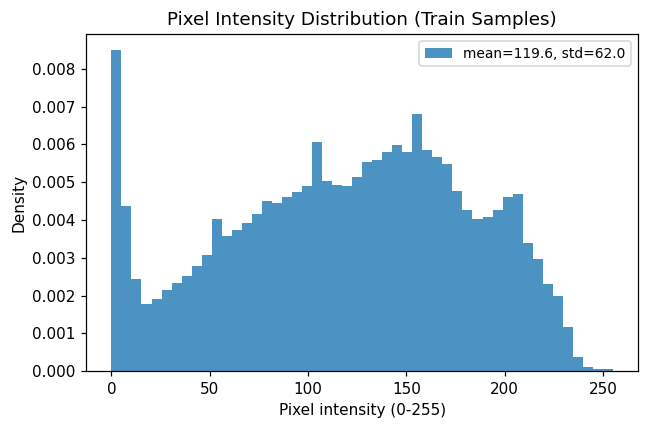

In [32]:
# ====== EDA: pixel intensity distribution on training images ======
import random
from PIL import Image

# 最多抽 100 张图
all_paths = train_df["full_path"].tolist()
sample_paths = random.sample(all_paths, k=min(10, len(all_paths)))

pixels = []

for fp in sample_paths:
    img = Image.open(fp).convert("L")  # 灰度
    arr = np.array(img, dtype=np.float32)
    pixels.extend(arr.ravel())

pixels = np.array(pixels)
mean_pix = pixels.mean()
std_pix  = pixels.std()

plt.figure(figsize=(6, 4))
plt.hist(pixels, bins=50, density=True, alpha=0.8)

plt.xlabel("Pixel intensity (0-255)")
plt.ylabel("Density")
plt.title("Pixel Intensity Distribution (Train Samples)")

# legend 带 mean/std
plt.legend(
    [f"mean={mean_pix:.1f}, std={std_pix:.1f}"],
    loc="upper right",
    fontsize=9
)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(EDA_DIR, "pixel_intensity_hist_train.png"), dpi=300)
plt.close()


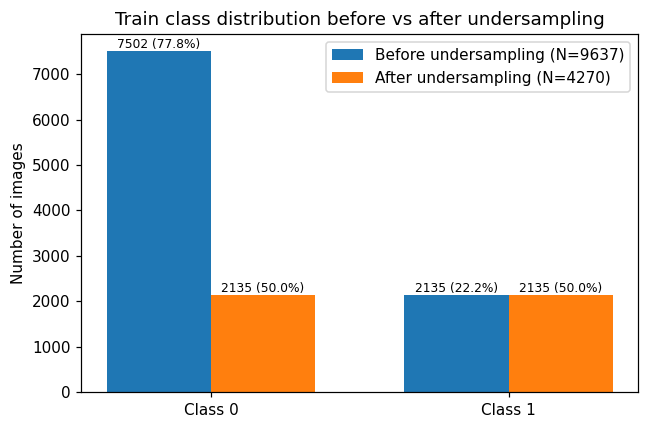

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base6_Output\class_dist_before_after_undersampling.png


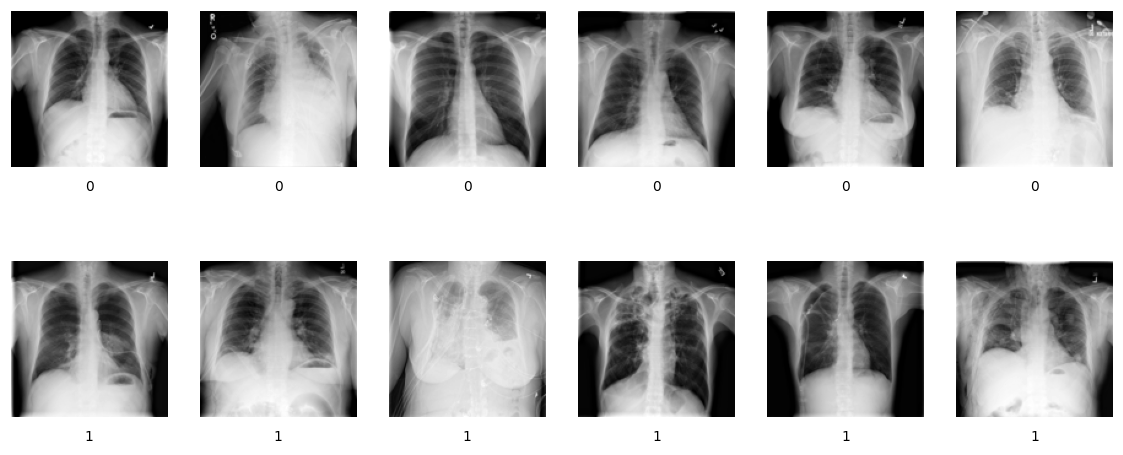

In [33]:
import matplotlib.pyplot as plt
import numpy as np

before_counts = train_tmp["has_pneumo"].value_counts().sort_index()
after_counts  = tr_df["has_pneumo"].value_counts().sort_index()

classes = before_counts.index.tolist() 
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(6, 4))

bars_before = plt.bar(x - width/2, before_counts.values,
                      width, label=f"Before undersampling (N={len(train_tmp)})")
bars_after  = plt.bar(x + width/2, after_counts.values,
                      width, label=f"After undersampling (N={len(tr_df)})")

total_before = before_counts.sum()
total_after  = after_counts.sum()

for bar, count in zip(bars_before, before_counts.values):
    pct = 100.0 * count / total_before
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f"{count} ({pct:.1f}%)",
             ha="center", va="bottom", fontsize=8)

for bar, count in zip(bars_after, after_counts.values):
    pct = 100.0 * count / total_after
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f"{count} ({pct:.1f}%)",
             ha="center", va="bottom", fontsize=8)

plt.xticks(x, [f"Class {c}" for c in classes])
plt.ylabel("Number of images")
plt.title("Train class distribution before vs after undersampling")
plt.legend()
plt.tight_layout()

save_path = os.path.join(OUT_DIR, "class_dist_before_after_undersampling.png")
plt.savefig(save_path, dpi=300)
plt.show()

print(f"[Info] Saved: {save_path}")


eda_sample_grid(train_df, os.path.join(EDA_DIR, "sample_grid_train.png"), "Train", n_per_class=6, size=128)

In [34]:
# Transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

# Joint transforms for image + mask (training set)
joint_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

# Datasets
ds_train = PandasImageMaskDataset(tr_df, mask_root=MASK_ROOT, joint_transform=joint_train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)


if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Use eval dataset for train_eval
ds_train_eval = PandasImageDataset(tr_df, transform=eval_tfms)
dl_train_eval = DataLoader(
    ds_train_eval, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True
)


len(ds_train), len(ds_val), len(ds_test)

(4270, 1205, 1205)

In [35]:
import os
import numpy as np
from PIL import Image

first_pos_idx = 1  

row = tr_df.iloc[first_pos_idx]
img_path = row["full_path"]
basename = os.path.basename(img_path)

print("img_path:", img_path)
print("basename:", basename)

print("MASK_ROOT:", MASK_ROOT)
mask_path = os.path.join(MASK_ROOT, basename)
print("mask_path:", mask_path, "exists:", os.path.exists(mask_path))

mask_raw = Image.open(mask_path).convert("L")
mask_np = np.array(mask_raw)

print("raw mask shape:", mask_np.shape)
print("raw mask min/max:", mask_np.min(), mask_np.max())
print("raw mask positive pixels (>0):", (mask_np > 0).sum())


img_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images\3808_train_0_.png
basename: 3808_train_0_.png
MASK_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks
mask_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks\3808_train_0_.png exists: True
raw mask shape: (1024, 1024)
raw mask min/max: 0 0
raw mask positive pixels (>0): 0


In [36]:
pos_indices = [i for i, v in enumerate(tr_df["has_pneumo"].values) if v == 1]
print("Positive sample number:", len(pos_indices))
first_pos_idx = pos_indices[0]

img, y, mask = ds_train[first_pos_idx]
print("index:", first_pos_idx)
print("label:", y)
print("mask shape:", mask.shape)
print("mask min/max:", mask.min().item(), mask.max().item())
print("mask positive pixels:", mask.sum().item())

Positive sample number: 2135
index: 4
label: 1.0
mask shape: torch.Size([1, 576, 576])
mask min/max: 0.0 1.0
mask positive pixels: 2197.0


# ConvNeXt_V2
## DropPath (Random Depth)

In [37]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # Only sample along batch dimension, broadcast others
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

## GRN

In [38]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

## LayerNorm2d

In [39]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

## ConvNeXt_V2 block

In [40]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  
    ):
        super().__init__()
        # 7x7 depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # Do LayerNorm in channels_last format
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## U-Net Decoder Block

In [41]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.has_skip = skip_ch > 0

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv1 = nn.Conv2d(in_ch + (skip_ch if skip_ch > 0 else 0),
                               out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.act   = nn.ReLU(inplace=True)

    def forward(self, x, skip=None):
        # Oversample
        x = self.upsample(x)

        if self.has_skip and skip is not None:
            if skip.shape[-2:] != x.shape[-2:]:
                skip = F.interpolate(skip, size=x.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([x, skip], dim=1)

        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        return x


## ConvNeXt_V2 tiny

In [42]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0, 
    ):
        super().__init__()

        # 4 deepths and dims for each stage
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # Constructing the stem: patch embedding with stride=4
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # Constructing the blocks and downsampling layers for each stage
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # Every stage begins with a downsampling layer (except the first)
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # The last classification head: LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Global average pooling and normalization
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    """
    ConvNeXtV2Tiny as encoder
    + U-Net decoder with skip connections
    + cls head (global pooling) + seg head
    """
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
    ):
        super().__init__()

        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,
        )

        # Channel dims at each stage of ConvNeXtV2Tiny
        dims = [96, 192, 384, 768]
        last_dim = dims[-1]   # The deepest 768

        # ===== Classification head =====
        self.cls_head = nn.Linear(last_dim, n_classes)

        # ===== U-Net decoder =====
        # encoder output: x1(1/4, 96), x2(1/8, 192), x3(1/16,384), x4(1/32,768)
        self.dec3 = DecoderBlock(in_ch=dims[3], skip_ch=dims[2], out_ch=dims[2])   # 1/32 -> 1/16
        self.dec2 = DecoderBlock(in_ch=dims[2], skip_ch=dims[1], out_ch=dims[1])   # 1/16 -> 1/8
        self.dec1 = DecoderBlock(in_ch=dims[1], skip_ch=dims[0], out_ch=dims[0])   # 1/8  -> 1/4
        self.dec0 = DecoderBlock(in_ch=dims[0], skip_ch=0,        out_ch=max(dims[0] // 2, 32))  # 1/4 -> 1/2

        # Segmentation head：convalution to 1 channel
        self.seg_head = nn.Conv2d(max(dims[0] // 2, 32), 1, kernel_size=1)

    def forward_backbone_pyramid(self, x):
        """
        Return feature pyramid from backbone
        x1: 1/4,  x2: 1/8,  x3: 1/16, x4: 1/32
        """
        feats = []
        for i in range(4):
            x = self.backbone.downsample_layers[i](x)
            x = self.backbone.stages[i](x)
            feats.append(x)
        return feats  # [x1, x2, x3, x4]

    def forward(self, x):
        # ---- Encoder ----
        x1, x2, x3, x4 = self.forward_backbone_pyramid(x)

        # ---- Classification branch----
        gap = x4.mean(dim=[2, 3])          # [B, C4]
        gap = self.backbone.norm_head(gap) 
        cls_logits = self.cls_head(gap)    # [B, 1]
        cls_logits = cls_logits.squeeze(1) # [B]

        # ---- U-Net Decoder + Segmentation head ----
        d3 = self.dec3(x4, x3)    # 1/32 -> 1/16
        d2 = self.dec2(d3, x2)    # 1/16 -> 1/8
        d1 = self.dec1(d2, x1)    # 1/8  -> 1/4
        d0 = self.dec0(d1, None)  # 1/4  -> 1/2

        seg_logits = self.seg_head(d0)  # [B,1,H_dec,W_dec]

        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        return cls_logits, seg_logits

model = ConvNeXtV2TinyScratch(in_chans=1, n_classes=1, drop_path_rate=0.1).to(device)

## Parameter counts

In [43]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params:      {total:,}")
    print(f"Trainable params:  {trainable:,}")
    print(f"Total params (M):  {total / 1e6:.2f} M")
    print(f"Trainable (M):     {trainable / 1e6:.2f} M")

count_parameters(model)


Total params:      34,898,835
Trainable params:  34,898,835
Total params (M):  34.90 M
Trainable (M):     34.90 M


## Loss：Tversky + Focal

### Tversky Loss

In [44]:
# Weights initialization
LAMBDA_SEG = 0.3

class TverskyLoss(nn.Module):
    def __init__(self, alpha: float = 0.3, beta: float = 0.7,
                 smooth: float = 1e-6, pos_only: bool = True):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.pos_only = pos_only

    def forward(self, logits, targets):
        """
        logits: [B,1,H,W]
        targets: [B,1,H,W] (0/1)
        """
        probs = torch.sigmoid(logits)
        targets = targets.float()

        B = probs.size(0)
        probs_flat   = probs.view(B, -1)
        targets_flat = targets.view(B, -1)

        # Only calculate positive sample using Tversky
        if self.pos_only:
            pos_mask = (targets_flat.sum(dim=1) > 0)
            if pos_mask.any():
                probs_flat   = probs_flat[pos_mask]
                targets_flat = targets_flat[pos_mask]
            else:
                return logits.new_tensor(0.0)

        TP = (probs_flat * targets_flat).sum(dim=1)
        FP = (probs_flat * (1.0 - targets_flat)).sum(dim=1)
        FN = ((1.0 - probs_flat) * targets_flat).sum(dim=1)

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        loss = 1.0 - tversky
        return loss.mean()

### Focal Loss

In [45]:
# Calculate class weights for Focal Loss
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

alpha = neg / (pos + neg + 1e-8)  

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# Define Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # Probabilities for the true class
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # Weighted alpha factor
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal weight
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # Basic BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Create criterion, optimizer, scheduler, scaler
criterion_cls  = BinaryFocalLoss(alpha=alpha, gamma=2.0)   # clf
criterion_segF = BinaryFocalLoss(alpha=0.5,   gamma=2.0)   # seg
criterion_segT = TverskyLoss(alpha=0.3, beta=0.7, pos_only=True)

# Optimizer / Scheduler / AMP
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=2135, neg=2135, alpha=0.5000


C:\Users\Steven\AppData\Local\Temp\ipykernel_9852\3234299231.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [46]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys, preds, scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        out = model(xb)
        if isinstance(out, tuple):
            logits, _ = out          # (cls_logits, seg_logits) → cls_logits
        else:
            logits = out

        probs = torch.sigmoid(logits)  # [B]
        pred = (probs >= 0.5).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(ys)
    y_pred = np.array(preds)
    y_score = np.array(scores)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity = TN / (TN + FP)
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    # ROC-AUC & PR-AUC
    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }
    return metrics, y_true, y_pred, y_score

def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

def plot_accuracy_curve(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs  = np.arange(1, best_epoch + 1)
    val_acc = np.array(history["val_acc"][:best_epoch]) * 100.0

    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_acc, marker="o", label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy (%)")
    plt.title(f"Learning Curve (Val Accuracy, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_acc_best.png"), dpi=300)
    plt.show()

In [47]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.downsample_layers.0.0.weight
backbone.downsample_layers.0.0.bias
backbone.downsample_layers.0.1.weight
backbone.downsample_layers.0.1.bias
backbone.downsample_layers.1.0.weight
backbone.downsample_layers.1.0.bias
backbone.downsample_layers.1.1.weight
backbone.downsample_layers.1.1.bias
backbone.downsample_layers.2.0.weight
backbone.downsample_layers.2.0.bias
backbone.downsample_layers.2.1.weight
backbone.downsample_layers.2.1.bias
backbone.downsample_layers.3.0.weight
backbone.downsample_layers.3.0.bias
backbone.downsample_layers.3.1.weight
backbone.downsample_layers.3.1.bias
backbone.stages.0.0.dwconv.weight
backbone.stages.0.0.dwconv.bias
backbone.stages.0.0.norm.weight
backbone.stages.0.0.norm.bias
backbone.stages.0.0.pwconv1.weight
backbone.stages.0.0.pwconv1.bias
backbone.stages.0.0.grn.gamma
backbone.stages.0.0.grn.beta
backbone.stages.0.0.pwconv2.weight
backbone.stages.0.0.pwconv2.bias
backbone.stages.0.1.dwconv.weight
backbone.stages.0.1.dwconv.bias
backbone.stages.0.1

In [48]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_acc":  [],
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running, running_cls, running_seg, nb = 0.0, 0.0, 0.0, 0 
    
    train_correct = 0
    train_total   = 0

    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb, mb in dl_train:   # clf + seg
        xb = xb.to(device, non_blocking=True)         # [B, 1, H, W]
        yb = yb.to(device, non_blocking=True).float() # [B]
        mb = mb.to(device, non_blocking=True).float() # [B, 1, H, W]

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            cls_logits, seg_logits = model(xb)   # cls_logits: [B] or [B,1], seg_logits: [B,1,H,W]

            # Classification branch：Focal Loss
            cls_loss = criterion_cls(cls_logits, yb)

            # Segmentation branch：Focal Loss + Tversky Loss
            seg_loss_focal   = criterion_segF(seg_logits, mb)
            seg_loss_tversky = criterion_segT(seg_logits, mb)
            seg_loss = seg_loss_focal + seg_loss_tversky

            # Total loss
            loss = cls_loss + LAMBDA_SEG * seg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Sum of three losses
        running      += loss.item()
        running_cls  += cls_loss.item()
        running_seg  += seg_loss.item()
        nb           += 1

        # 👉 这里顺便统计训练集 accuracy
        with torch.no_grad():
            # 保证 logits 展平为 [B]
            if cls_logits.ndim > 1:
                cls_logits_batch = cls_logits.view(-1)
            else:
                cls_logits_batch = cls_logits

            probs = torch.sigmoid(cls_logits_batch)
            preds = (probs >= 0.5).float()     # 阈值 0.5
            train_correct += (preds == yb).sum().item()
            train_total   += yb.size(0)

        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]

        bar.set_postfix(
            loss=f"{running / max(nb, 1):.4f}",
            cls=f"{running_cls / max(nb, 1):.4f}",
            seg=f"{running_seg / max(nb, 1):.8f}",
            lr=f"{curr_lr:.2e}",
        )
        bar.update(1)

    scheduler.step()
    bar.close()

    train_loss_epoch = running / max(nb, 1)
    train_acc_epoch  = train_correct / max(train_total, 1)

    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()

            with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
                out = model(xb)
                if isinstance(out, tuple):
                    logits, _ = out
                else:
                    logits = out
                loss_val = criterion_cls(logits, yb)

            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    history["train_acc"].append(train_acc_epoch)
    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"train_acc={train_acc_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# Save best model
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)


[Info] Start training...


Epoch 1/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 01/120 train_loss=0.3632 val_loss=0.0738 train_acc=0.5000 val_acc=0.7784 val_prec=0.0000 val_rec=0.0000 val_f1=0.0000 val_spec=1.0000 val_roc=0.6462 val_pr=0.2991 | val_pr_auc=0.2991 best_pr_auc=0.2991 (epoch 1)


Epoch 2/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 02/120 train_loss=0.3107 val_loss=0.0716 train_acc=0.5082 val_acc=0.7784 val_prec=0.0000 val_rec=0.0000 val_f1=0.0000 val_spec=1.0000 val_roc=0.6093 val_pr=0.2887 | val_pr_auc=0.2887 best_pr_auc=0.2991 (epoch 1)


Epoch 3/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 03/120 train_loss=0.2967 val_loss=0.0777 train_acc=0.5225 val_acc=0.7668 val_prec=0.2812 val_rec=0.0337 val_f1=0.0602 val_spec=0.9755 val_roc=0.6367 val_pr=0.2912 | val_pr_auc=0.2912 best_pr_auc=0.2991 (epoch 1)


Epoch 4/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 04/120 train_loss=0.2926 val_loss=0.0703 train_acc=0.5405 val_acc=0.7768 val_prec=0.0000 val_rec=0.0000 val_f1=0.0000 val_spec=0.9979 val_roc=0.6588 val_pr=0.3185 | val_pr_auc=0.3185 best_pr_auc=0.3185 (epoch 4)


Epoch 5/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 05/120 train_loss=0.2838 val_loss=0.1115 train_acc=0.5674 val_acc=0.2481 val_prec=0.2262 val_rec=0.9888 val_f1=0.3682 val_spec=0.0373 val_roc=0.6490 val_pr=0.3268 | val_pr_auc=0.3268 best_pr_auc=0.3268 (epoch 5)


Epoch 6/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 06/120 train_loss=0.2800 val_loss=0.0794 train_acc=0.6208 val_acc=0.6349 val_prec=0.3566 val_rec=0.8052 val_f1=0.4943 val_spec=0.5864 val_roc=0.7429 val_pr=0.4209 | val_pr_auc=0.4209 best_pr_auc=0.4209 (epoch 6)


Epoch 7/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 07/120 train_loss=0.2741 val_loss=0.0835 train_acc=0.6407 val_acc=0.6382 val_prec=0.3617 val_rec=0.8277 val_f1=0.5034 val_spec=0.5842 val_roc=0.7548 val_pr=0.4398 | val_pr_auc=0.4398 best_pr_auc=0.4398 (epoch 7)


Epoch 8/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 08/120 train_loss=0.2681 val_loss=0.1002 train_acc=0.6487 val_acc=0.4290 val_prec=0.2724 val_rec=0.9438 val_f1=0.4228 val_spec=0.2825 val_roc=0.7494 val_pr=0.4700 | val_pr_auc=0.4700 best_pr_auc=0.4700 (epoch 8)


Epoch 9/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 09/120 train_loss=0.2607 val_loss=0.0848 train_acc=0.6735 val_acc=0.5983 val_prec=0.3368 val_rec=0.8390 val_f1=0.4807 val_spec=0.5299 val_roc=0.7662 val_pr=0.4813 | val_pr_auc=0.4813 best_pr_auc=0.4813 (epoch 9)


Epoch 10/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 10/120 train_loss=0.2611 val_loss=0.0754 train_acc=0.6799 val_acc=0.6697 val_prec=0.3910 val_rec=0.8801 val_f1=0.5415 val_spec=0.6098 val_roc=0.8220 val_pr=0.5574 | val_pr_auc=0.5574 best_pr_auc=0.5574 (epoch 10)


Epoch 11/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 11/120 train_loss=0.2542 val_loss=0.0747 train_acc=0.7012 val_acc=0.6855 val_prec=0.4024 val_rec=0.8652 val_f1=0.5493 val_spec=0.6343 val_roc=0.8180 val_pr=0.5421 | val_pr_auc=0.5421 best_pr_auc=0.5574 (epoch 10)


Epoch 12/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 12/120 train_loss=0.2501 val_loss=0.0696 train_acc=0.7194 val_acc=0.7253 val_prec=0.4319 val_rec=0.7603 val_f1=0.5509 val_spec=0.7154 val_roc=0.8193 val_pr=0.5673 | val_pr_auc=0.5673 best_pr_auc=0.5673 (epoch 12)


Epoch 13/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 13/120 train_loss=0.2490 val_loss=0.0735 train_acc=0.7340 val_acc=0.6988 val_prec=0.4172 val_rec=0.9064 val_f1=0.5714 val_spec=0.6397 val_roc=0.8493 val_pr=0.6154 | val_pr_auc=0.6154 best_pr_auc=0.6154 (epoch 13)


Epoch 14/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 14/120 train_loss=0.2442 val_loss=0.0733 train_acc=0.7316 val_acc=0.7095 val_prec=0.4252 val_rec=0.8839 val_f1=0.5742 val_spec=0.6599 val_roc=0.8550 val_pr=0.6141 | val_pr_auc=0.6141 best_pr_auc=0.6154 (epoch 13)


Epoch 15/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 15/120 train_loss=0.2485 val_loss=0.0809 train_acc=0.7370 val_acc=0.6614 val_prec=0.3879 val_rec=0.9139 val_f1=0.5446 val_spec=0.5896 val_roc=0.8492 val_pr=0.5983 | val_pr_auc=0.5983 best_pr_auc=0.6154 (epoch 13)


Epoch 16/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 16/120 train_loss=0.2370 val_loss=0.0730 train_acc=0.7569 val_acc=0.7145 val_prec=0.4296 val_rec=0.8801 val_f1=0.5774 val_spec=0.6674 val_roc=0.8560 val_pr=0.6362 | val_pr_auc=0.6362 best_pr_auc=0.6362 (epoch 16)


Epoch 17/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 17/120 train_loss=0.2405 val_loss=0.0698 train_acc=0.7461 val_acc=0.7361 val_prec=0.4499 val_rec=0.8577 val_f1=0.5902 val_spec=0.7015 val_roc=0.8493 val_pr=0.6197 | val_pr_auc=0.6197 best_pr_auc=0.6362 (epoch 16)


Epoch 18/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 18/120 train_loss=0.2352 val_loss=0.0643 train_acc=0.7494 val_acc=0.7527 val_prec=0.4682 val_rec=0.8539 val_f1=0.6048 val_spec=0.7239 val_roc=0.8515 val_pr=0.6320 | val_pr_auc=0.6320 best_pr_auc=0.6362 (epoch 16)


Epoch 19/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 19/120 train_loss=0.2329 val_loss=0.0718 train_acc=0.7766 val_acc=0.7228 val_prec=0.4312 val_rec=0.7865 val_f1=0.5570 val_spec=0.7047 val_roc=0.8339 val_pr=0.5942 | val_pr_auc=0.5942 best_pr_auc=0.6362 (epoch 16)


Epoch 20/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 20/120 train_loss=0.2318 val_loss=0.0628 train_acc=0.7742 val_acc=0.7560 val_prec=0.4719 val_rec=0.8502 val_f1=0.6070 val_spec=0.7292 val_roc=0.8654 val_pr=0.6393 | val_pr_auc=0.6393 best_pr_auc=0.6393 (epoch 20)


Epoch 21/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 21/120 train_loss=0.2263 val_loss=0.0697 train_acc=0.7810 val_acc=0.7361 val_prec=0.4520 val_rec=0.8989 val_f1=0.6015 val_spec=0.6898 val_roc=0.8728 val_pr=0.6530 | val_pr_auc=0.6530 best_pr_auc=0.6530 (epoch 21)


Epoch 22/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 22/120 train_loss=0.2274 val_loss=0.0568 train_acc=0.7808 val_acc=0.7917 val_prec=0.5214 val_rec=0.7303 val_f1=0.6084 val_spec=0.8092 val_roc=0.8568 val_pr=0.6373 | val_pr_auc=0.6373 best_pr_auc=0.6530 (epoch 21)


Epoch 23/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 23/120 train_loss=0.2265 val_loss=0.0471 train_acc=0.7906 val_acc=0.8340 val_prec=0.6192 val_rec=0.6517 val_f1=0.6350 val_spec=0.8859 val_roc=0.8798 val_pr=0.6708 | val_pr_auc=0.6708 best_pr_auc=0.6708 (epoch 23)


Epoch 24/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 24/120 train_loss=0.2192 val_loss=0.0555 train_acc=0.7953 val_acc=0.8025 val_prec=0.5371 val_rec=0.7865 val_f1=0.6383 val_spec=0.8070 val_roc=0.8758 val_pr=0.6825 | val_pr_auc=0.6825 best_pr_auc=0.6825 (epoch 24)


Epoch 25/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 25/120 train_loss=0.2229 val_loss=0.0832 train_acc=0.7937 val_acc=0.6697 val_prec=0.3969 val_rec=0.9438 val_f1=0.5588 val_spec=0.5917 val_roc=0.8843 val_pr=0.6901 | val_pr_auc=0.6901 best_pr_auc=0.6901 (epoch 25)


Epoch 26/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 26/120 train_loss=0.2197 val_loss=0.0593 train_acc=0.7904 val_acc=0.7876 val_prec=0.5128 val_rec=0.8277 val_f1=0.6332 val_spec=0.7761 val_roc=0.8826 val_pr=0.6853 | val_pr_auc=0.6853 best_pr_auc=0.6901 (epoch 25)


Epoch 27/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 27/120 train_loss=0.2148 val_loss=0.0550 train_acc=0.8056 val_acc=0.8050 val_prec=0.5400 val_rec=0.8090 val_f1=0.6477 val_spec=0.8038 val_roc=0.8808 val_pr=0.6685 | val_pr_auc=0.6685 best_pr_auc=0.6901 (epoch 25)


Epoch 28/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 28/120 train_loss=0.2145 val_loss=0.0649 train_acc=0.8162 val_acc=0.7544 val_prec=0.4711 val_rec=0.8839 val_f1=0.6146 val_spec=0.7175 val_roc=0.8806 val_pr=0.6852 | val_pr_auc=0.6852 best_pr_auc=0.6901 (epoch 25)


Epoch 29/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 29/120 train_loss=0.2136 val_loss=0.0476 train_acc=0.8131 val_acc=0.8382 val_prec=0.6118 val_rec=0.7378 val_f1=0.6689 val_spec=0.8667 val_roc=0.8871 val_pr=0.6911 | val_pr_auc=0.6911 best_pr_auc=0.6911 (epoch 29)


Epoch 30/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 30/120 train_loss=0.2085 val_loss=0.0514 train_acc=0.8206 val_acc=0.8249 val_prec=0.5745 val_rec=0.8090 val_f1=0.6719 val_spec=0.8294 val_roc=0.8929 val_pr=0.7096 | val_pr_auc=0.7096 best_pr_auc=0.7096 (epoch 30)


Epoch 31/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 31/120 train_loss=0.2059 val_loss=0.0630 train_acc=0.8283 val_acc=0.7618 val_prec=0.4800 val_rec=0.8989 val_f1=0.6258 val_spec=0.7228 val_roc=0.8993 val_pr=0.7126 | val_pr_auc=0.7126 best_pr_auc=0.7126 (epoch 31)


Epoch 32/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 32/120 train_loss=0.2019 val_loss=0.0732 train_acc=0.8248 val_acc=0.7585 val_prec=0.4753 val_rec=0.8652 val_f1=0.6135 val_spec=0.7281 val_roc=0.8773 val_pr=0.6770 | val_pr_auc=0.6770 best_pr_auc=0.7126 (epoch 31)


Epoch 33/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 33/120 train_loss=0.2022 val_loss=0.0607 train_acc=0.8314 val_acc=0.7892 val_prec=0.5142 val_rec=0.8839 val_f1=0.6501 val_spec=0.7623 val_roc=0.8956 val_pr=0.7005 | val_pr_auc=0.7005 best_pr_auc=0.7126 (epoch 31)


Epoch 34/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 34/120 train_loss=0.1960 val_loss=0.0509 train_acc=0.8403 val_acc=0.8241 val_prec=0.5711 val_rec=0.8277 val_f1=0.6758 val_spec=0.8230 val_roc=0.8980 val_pr=0.7028 | val_pr_auc=0.7028 best_pr_auc=0.7126 (epoch 31)


Epoch 35/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 35/120 train_loss=0.1973 val_loss=0.0632 train_acc=0.8431 val_acc=0.7660 val_prec=0.4851 val_rec=0.9176 val_f1=0.6347 val_spec=0.7228 val_roc=0.9097 val_pr=0.7358 | val_pr_auc=0.7358 best_pr_auc=0.7358 (epoch 35)


Epoch 36/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 36/120 train_loss=0.1959 val_loss=0.0812 train_acc=0.8426 val_acc=0.7386 val_prec=0.4544 val_rec=0.8951 val_f1=0.6028 val_spec=0.6940 val_roc=0.8812 val_pr=0.6927 | val_pr_auc=0.6927 best_pr_auc=0.7358 (epoch 35)


Epoch 37/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 37/120 train_loss=0.1920 val_loss=0.0667 train_acc=0.8513 val_acc=0.7734 val_prec=0.4939 val_rec=0.9026 val_f1=0.6384 val_spec=0.7367 val_roc=0.8973 val_pr=0.7117 | val_pr_auc=0.7117 best_pr_auc=0.7358 (epoch 35)


Epoch 38/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 38/120 train_loss=0.1887 val_loss=0.0572 train_acc=0.8574 val_acc=0.8174 val_prec=0.5580 val_rec=0.8464 val_f1=0.6726 val_spec=0.8092 val_roc=0.8975 val_pr=0.7031 | val_pr_auc=0.7031 best_pr_auc=0.7358 (epoch 35)


Epoch 39/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 39/120 train_loss=0.1896 val_loss=0.0664 train_acc=0.8553 val_acc=0.7701 val_prec=0.4895 val_rec=0.8727 val_f1=0.6272 val_spec=0.7409 val_roc=0.8894 val_pr=0.6922 | val_pr_auc=0.6922 best_pr_auc=0.7358 (epoch 35)


Epoch 40/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 40/120 train_loss=0.1838 val_loss=0.0573 train_acc=0.8656 val_acc=0.8216 val_prec=0.5647 val_rec=0.8502 val_f1=0.6786 val_spec=0.8134 val_roc=0.9053 val_pr=0.7366 | val_pr_auc=0.7366 best_pr_auc=0.7366 (epoch 40)


Epoch 41/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 41/120 train_loss=0.1819 val_loss=0.0504 train_acc=0.8698 val_acc=0.8432 val_prec=0.6048 val_rec=0.8427 val_f1=0.7042 val_spec=0.8433 val_roc=0.9083 val_pr=0.7328 | val_pr_auc=0.7328 best_pr_auc=0.7366 (epoch 40)


Epoch 42/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 42/120 train_loss=0.1814 val_loss=0.0440 train_acc=0.8813 val_acc=0.8664 val_prec=0.6949 val_rec=0.7079 val_f1=0.7013 val_spec=0.9115 val_roc=0.9126 val_pr=0.7541 | val_pr_auc=0.7541 best_pr_auc=0.7541 (epoch 42)


Epoch 43/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 43/120 train_loss=0.1778 val_loss=0.0579 train_acc=0.8845 val_acc=0.8290 val_prec=0.5735 val_rec=0.8914 val_f1=0.6979 val_spec=0.8113 val_roc=0.9137 val_pr=0.7478 | val_pr_auc=0.7478 best_pr_auc=0.7541 (epoch 42)


Epoch 44/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 44/120 train_loss=0.1743 val_loss=0.0587 train_acc=0.8909 val_acc=0.8224 val_prec=0.5674 val_rec=0.8352 val_f1=0.6758 val_spec=0.8188 val_roc=0.9127 val_pr=0.7395 | val_pr_auc=0.7395 best_pr_auc=0.7541 (epoch 42)


Epoch 45/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 45/120 train_loss=0.1698 val_loss=0.0502 train_acc=0.8909 val_acc=0.8548 val_prec=0.6655 val_rec=0.6929 val_f1=0.6789 val_spec=0.9009 val_roc=0.9064 val_pr=0.7038 | val_pr_auc=0.7038 best_pr_auc=0.7541 (epoch 42)


Epoch 46/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 46/120 train_loss=0.1697 val_loss=0.0578 train_acc=0.8930 val_acc=0.8349 val_prec=0.5842 val_rec=0.8839 val_f1=0.7034 val_spec=0.8209 val_roc=0.9175 val_pr=0.7535 | val_pr_auc=0.7535 best_pr_auc=0.7541 (epoch 42)


Epoch 47/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 47/120 train_loss=0.1681 val_loss=0.0642 train_acc=0.9037 val_acc=0.7967 val_prec=0.5241 val_rec=0.8951 val_f1=0.6611 val_spec=0.7687 val_roc=0.9115 val_pr=0.7364 | val_pr_auc=0.7364 best_pr_auc=0.7541 (epoch 42)


Epoch 48/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 48/120 train_loss=0.1631 val_loss=0.0621 train_acc=0.9098 val_acc=0.8100 val_prec=0.5444 val_rec=0.8727 val_f1=0.6705 val_spec=0.7921 val_roc=0.9002 val_pr=0.7130 | val_pr_auc=0.7130 best_pr_auc=0.7541 (epoch 42)


Epoch 49/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 49/120 train_loss=0.1655 val_loss=0.0578 train_acc=0.9070 val_acc=0.8423 val_prec=0.6043 val_rec=0.8352 val_f1=0.7013 val_spec=0.8443 val_roc=0.9092 val_pr=0.7475 | val_pr_auc=0.7475 best_pr_auc=0.7541 (epoch 42)


Epoch 50/120:   0%|          | 0/1068 [00:00<?, ?it/s]

Epoch 50/120 train_loss=0.1608 val_loss=0.0679 train_acc=0.9124 val_acc=0.8108 val_prec=0.5455 val_rec=0.8764 val_f1=0.6724 val_spec=0.7921 val_roc=0.9097 val_pr=0.7466 | val_pr_auc=0.7466 best_pr_auc=0.7541 (epoch 42)
[EarlyStop] Stop at epoch 50. Best pr_auc=0.7541 @ epoch 42.


[Info] Saved training history to: ./ConvNeXt+UNet(8,1,1)_base6_Output\history_base6.csv


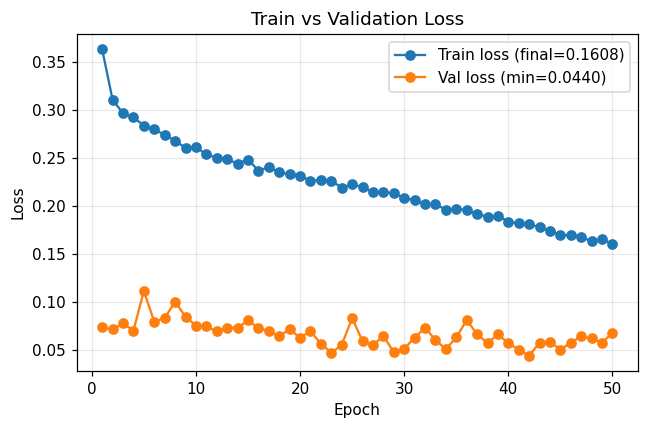

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base6_Output\curve_loss_train_vs_val.png


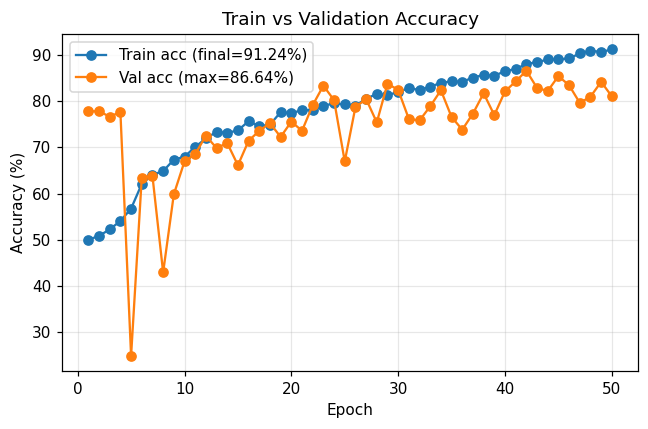

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base6_Output\curve_acc_train_vs_val.png


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

hist_df = pd.DataFrame(history)
hist_df["epoch"] = np.arange(1, len(hist_df) + 1)

# 可选：把 history 保存一下，之后多模型对比也能用
history_csv_path = os.path.join(OUT_DIR, "history_base6.csv")
hist_df.to_csv(history_csv_path, index=False)
print(f"[Info] Saved training history to: {history_csv_path}")

epochs = hist_df["epoch"].values

# =========================
# 2. Loss：Train vs Val
# =========================
plt.figure(figsize=(6, 4))

train_loss = hist_df["train_loss"].values
val_loss   = hist_df["val_loss"].values

plt.plot(
    epochs,
    train_loss,
    marker="o",
    label=f"Train loss (final={train_loss[-1]:.4f})"
)
plt.plot(
    epochs,
    val_loss,
    marker="o",
    label=f"Val loss (min={val_loss.min():.4f})"
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

loss_fig_path = os.path.join(OUT_DIR, "curve_loss_train_vs_val.png")
plt.savefig(loss_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {loss_fig_path}")

# =========================
# 3. Accuracy：Train vs Val
# =========================
plt.figure(figsize=(6, 4))

train_acc = hist_df["train_acc"].values * 100.0  
val_acc   = hist_df["val_acc"].values * 100.0

plt.plot(
    epochs,
    train_acc,
    marker="o",
    label=f"Train acc (final={train_acc[-1]:.2f}%)"
)
plt.plot(
    epochs,
    val_acc,
    marker="o",
    label=f"Val acc (max={val_acc.max():.2f}%)"
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

acc_fig_path = os.path.join(OUT_DIR, "curve_acc_train_vs_val.png")
plt.savefig(acc_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {acc_fig_path}")

## Accuracy & Loss comparison

[Info] Saved training history to: ./ConvNeXt+UNet(8,1,1)_base6_Output\history_base6.csv


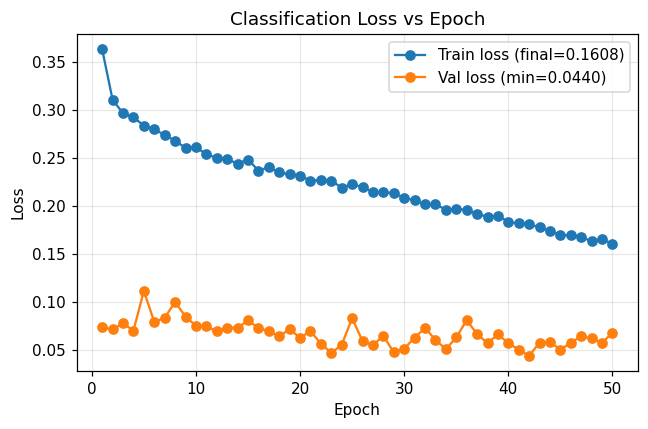

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base6_Output\curve_loss_train_vs_val.png


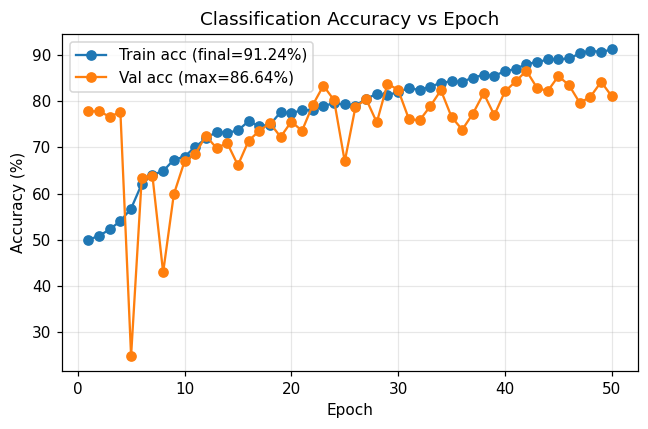

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base6_Output\curve_acc_train_vs_val.png


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

hist_df = pd.DataFrame(history)
hist_df["epoch"] = np.arange(1, len(hist_df) + 1)

history_csv_path = os.path.join(OUT_DIR, "history_base6.csv")
hist_df.to_csv(history_csv_path, index=False)
print(f"[Info] Saved training history to: {history_csv_path}")

epochs = hist_df["epoch"].values

plt.figure(figsize=(6, 4))
plt.plot(epochs, hist_df["train_loss"], marker="o",
         label=f"Train loss (final={hist_df['train_loss'].iloc[-1]:.4f})")
plt.plot(epochs, hist_df["val_loss"], marker="o",
         label=f"Val loss (min={hist_df['val_loss'].min():.4f})")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classification Loss vs Epoch")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

loss_fig_path = os.path.join(OUT_DIR, "curve_loss_train_vs_val.png")
plt.savefig(loss_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {loss_fig_path}")

plt.figure(figsize=(6, 4))
train_acc_pct = hist_df["train_acc"] * 100.0
val_acc_pct   = hist_df["val_acc"] * 100.0

plt.plot(epochs, train_acc_pct, marker="o",
         label=f"Train acc (final={train_acc_pct.iloc[-1]:.2f}%)")
plt.plot(epochs, val_acc_pct, marker="o",
         label=f"Val acc (max={val_acc_pct.max():.2f}%)")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Classification Accuracy vs Epoch")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

acc_fig_path = os.path.join(OUT_DIR, "curve_acc_train_vs_val.png")
plt.savefig(acc_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {acc_fig_path}")


[Best model @ Train]
Accuracy (%)        : 87.471
Precision (%)       : 95.61
Recall (%)          : 78.548
F1-Score (%)        : 86.243
Specificity (%)     : 96.393
ROC-AUC (%)         : 97.167
Precision-recall (%): 96.969

[Best model @ Val]
Accuracy (%)        : 86.639
Precision (%)       : 69.485
Recall (%)          : 70.787
F1-Score (%)        : 70.13
Specificity (%)     : 91.151
ROC-AUC (%)         : 91.256
Precision-recall (%): 75.411

[Best model @ Test]
Accuracy (%)        : 85.145
Precision (%)       : 68.033
Recall (%)          : 62.172
F1-Score (%)        : 64.971
Specificity (%)     : 91.684
ROC-AUC (%)         : 89.864
Precision-recall (%): 74.196


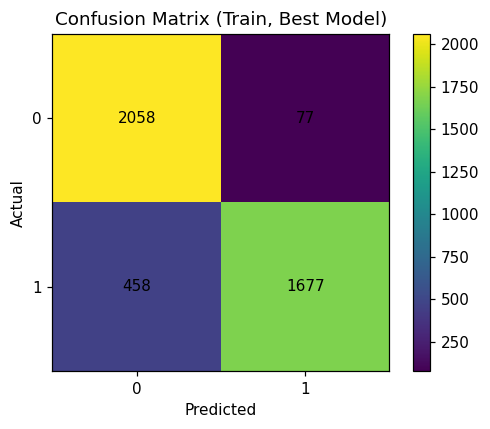

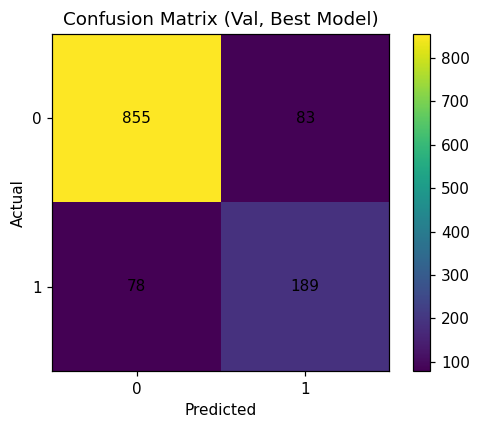

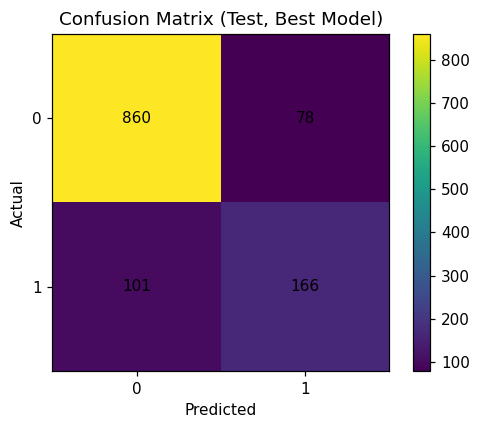

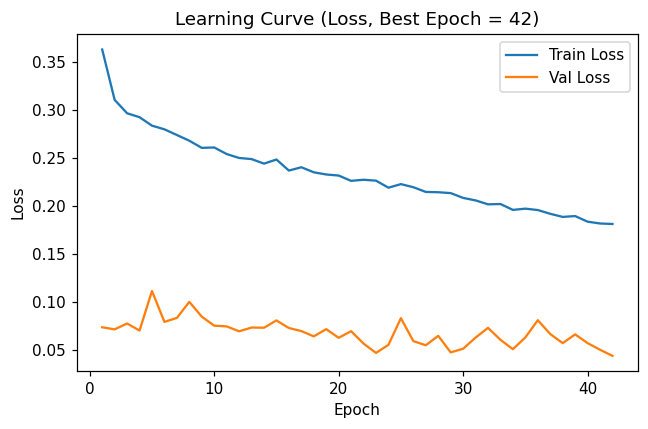

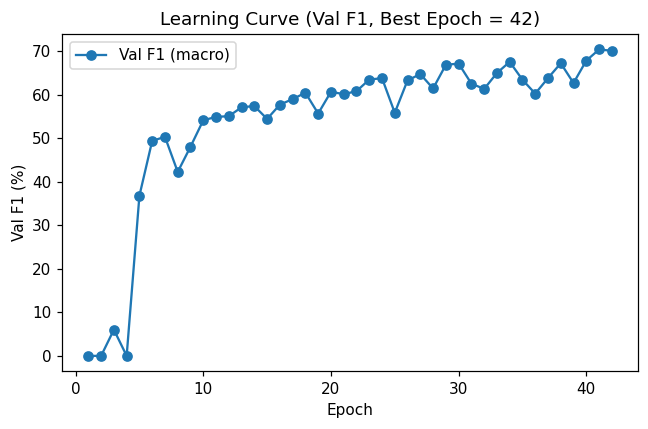

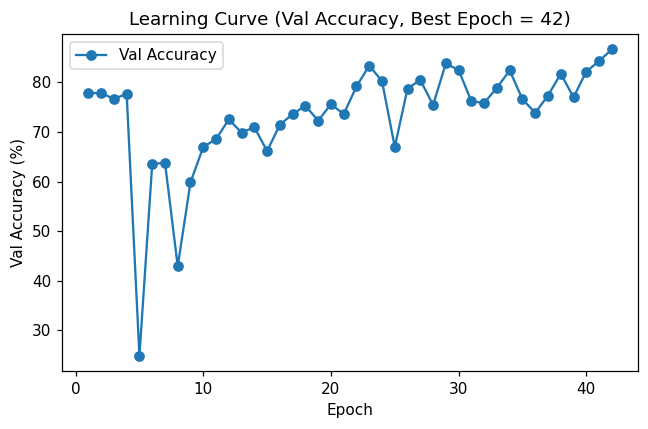

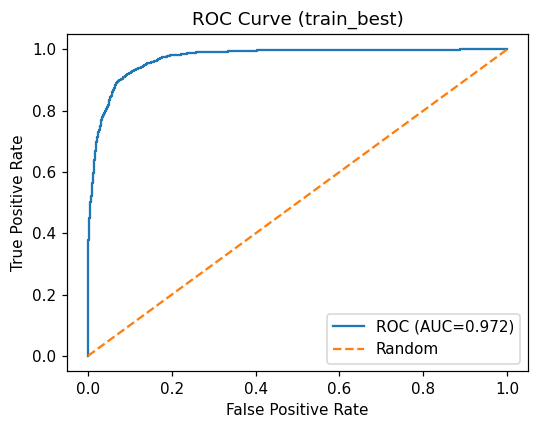

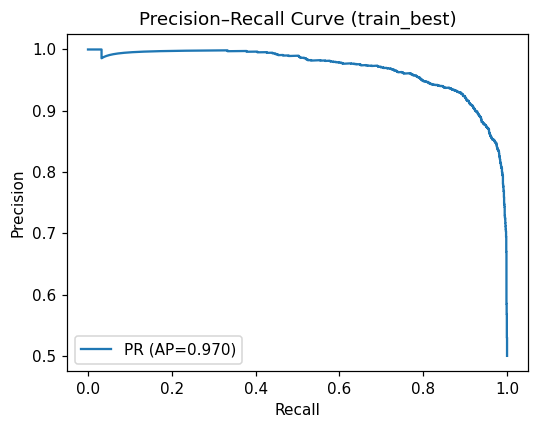

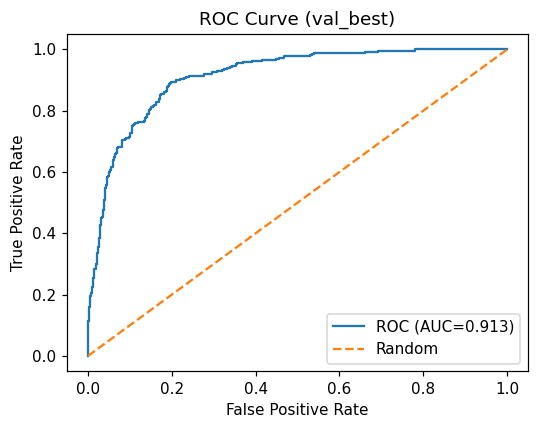

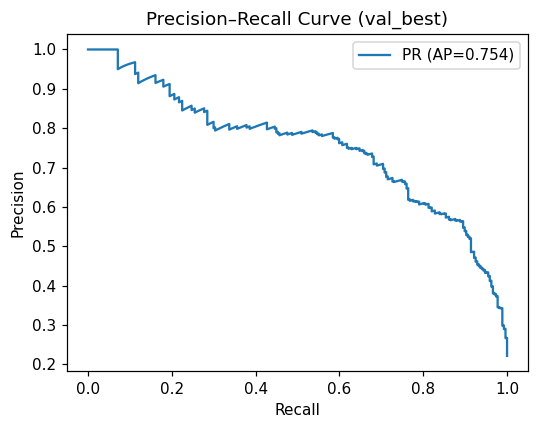

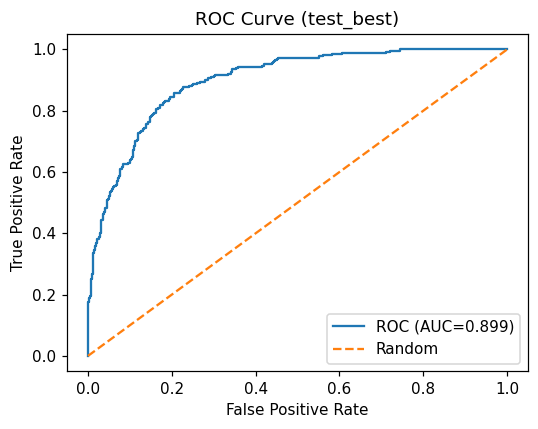

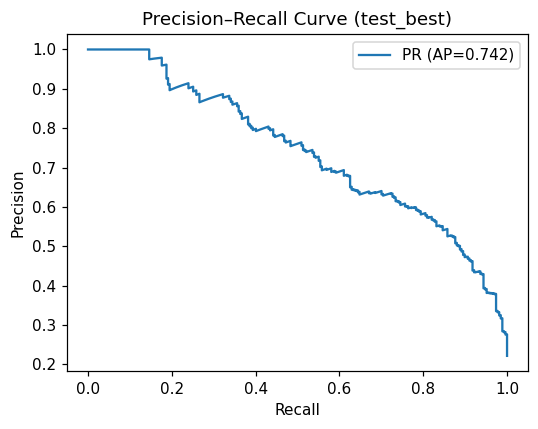

In [51]:
train_metrics_best, ytr_best, ptr_best, str_best = evaluate(model, dl_train_eval, device)
val_metrics_best,   yv_best,  pv_best,  sv_best  = evaluate(model, dl_val,        device)
test_metrics_best,  yt_best,  pt_best,  st_best  = evaluate(model, dl_test,       device)

train_pct = {k: round(v * 100, 3) for k, v in train_metrics_best.items()}
val_pct   = {k: round(v * 100, 3) for k, v in val_metrics_best.items()}
test_pct  = {k: round(v * 100, 3) for k, v in test_metrics_best.items()}

print("\n[Best model @ Train]")
print("Accuracy (%)        :", train_pct["acc"])
print("Precision (%)       :", train_pct["prec"])
print("Recall (%)          :", train_pct["rec"])
print("F1-Score (%)        :", train_pct["f1"])
print("Specificity (%)     :", train_pct["spec"])
print("ROC-AUC (%)         :", train_pct["roc_auc"])
print("Precision-recall (%):", train_pct["pr_auc"])

print("\n[Best model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[Best model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])

# confusion matrix
plot_confusion_matrix(
    ytr_best, ptr_best,
    out_path=os.path.join(OUT_DIR, "confmat_train_best.png"),
    title="Confusion Matrix (Train, Best Model)"
)

plot_confusion_matrix(
    yv_best, pv_best,
    out_path=os.path.join(OUT_DIR, "confmat_val_best.png"),
    title="Confusion Matrix (Val, Best Model)"
)

plot_confusion_matrix(
    yt_best, pt_best,
    out_path=os.path.join(OUT_DIR, "confmat_test_best.png"),
    title="Confusion Matrix (Test, Best Model)"
)

# learning curves
plot_learning_curves(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal"
)

plot_accuracy_curve(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal"
)

# roc/pr curves
plot_roc_pr(
    y_true=ytr_best,
    y_score=str_best,
    out_dir=OUT_DIR,
    prefix="train_best",
    roc_auc=train_metrics_best["roc_auc"],
    pr_auc=train_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yv_best,
    y_score=sv_best,
    out_dir=OUT_DIR,
    prefix="val_best",
    roc_auc=val_metrics_best["roc_auc"],
    pr_auc=val_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yt_best,
    y_score=st_best,
    out_dir=OUT_DIR,
    prefix="test_best",
    roc_auc=test_metrics_best["roc_auc"],
    pr_auc=test_metrics_best["pr_auc"]
)


##  Train / Val / Test Matrics Comparison

[Debug] metrics_df columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
[Info] Saved metrics summary to: ./ConvNeXt+UNet(8,1,1)_base6_Output\metrics_summary_base6.csv


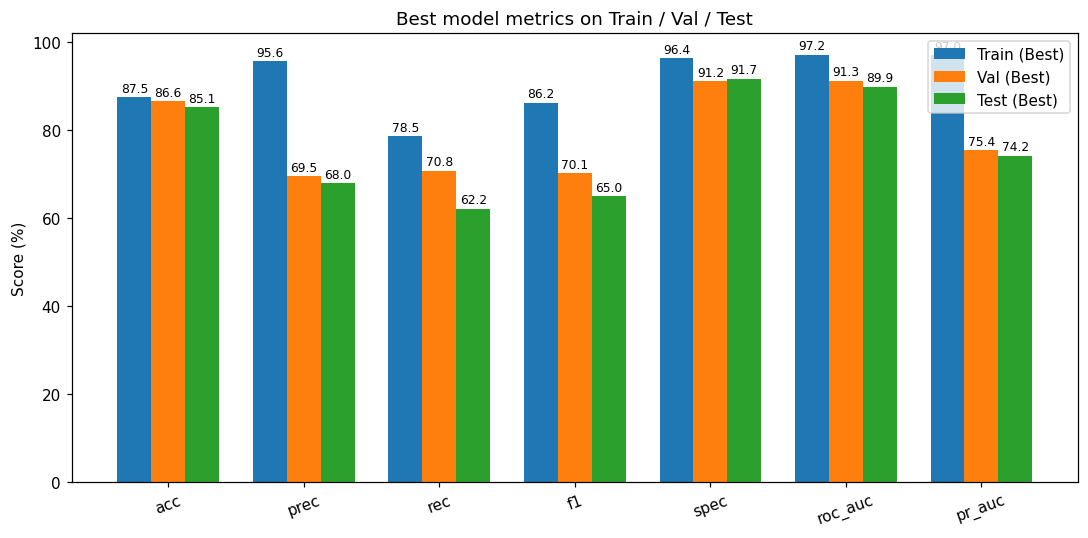

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base6_Output\metrics_bar_train_val_test_best.png


In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ===== 1. 组装 DataFrame =====
rows = [
    {"Split": "Train (Best)", **train_pct},
    {"Split": "Val (Best)",   **val_pct},
    {"Split": "Test (Best)",  **test_pct},
]

metrics_df = pd.DataFrame(rows)

# 把 Split 放到第一列，其他指标列保持原来的顺序
metric_cols = [c for c in metrics_df.columns if c != "Split"]
metrics_df = metrics_df[["Split"] + metric_cols]

print("[Debug] metrics_df columns:", list(metrics_df.columns))

# 保存 CSV
metrics_csv_path = os.path.join(OUT_DIR, "metrics_summary_base6.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"[Info] Saved metrics summary to: {metrics_csv_path}")

# ===== 2. 画柱状图：Train / Val / Test 指标对比 =====
x = np.arange(len(metric_cols))  # 每个指标一个 x 位置
width = 0.25                     # 每个 split 的柱宽

plt.figure(figsize=(10, 5))

for i, split in enumerate(metrics_df["Split"]):
    values = metrics_df.loc[i, metric_cols].values.astype(float)
    offset = (i - 1) * width  # -width, 0, +width 三组
    bars = plt.bar(x + offset, values, width, label=split)

    # 在柱子顶上标具体数值
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=8)

# x 轴标签稍微清洗一下：去掉 (%) 之类
xtick_labels = [
    c.replace("(%)", "").replace("%", "").strip()
    for c in metric_cols
]

plt.xticks(x, xtick_labels, rotation=20)
plt.ylabel("Score (%)")
plt.title("Best model metrics on Train / Val / Test")
plt.legend()
plt.tight_layout()

bar_fig_path = os.path.join(OUT_DIR, "metrics_bar_train_val_test_best.png")
plt.savefig(bar_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {bar_fig_path}")



=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.532 87.303 72.984 67.790 70.291 92.857
    0.480 85.809 66.438 72.659 69.410 89.552
    0.376 83.237 58.312 85.393 69.301 82.623
    0.428 84.315 61.404 78.652 68.966 85.928
    0.323 81.328 54.795 89.888 68.085 78.891
    0.584 87.054 77.612 58.427 66.667 95.203
    0.271 76.349 48.235 92.135 63.320 71.855
    0.637 85.643 78.313 48.689 60.046 96.162
    0.219 71.369 43.345 95.131 59.555 64.606
    0.167 63.817 37.736 97.378 54.393 54.264

Best threshold on validation set (by f1):
t = 0.532, Acc=87.303%, Prec=72.984%, Rec=67.790%, F1=70.291%, Spec=92.857%


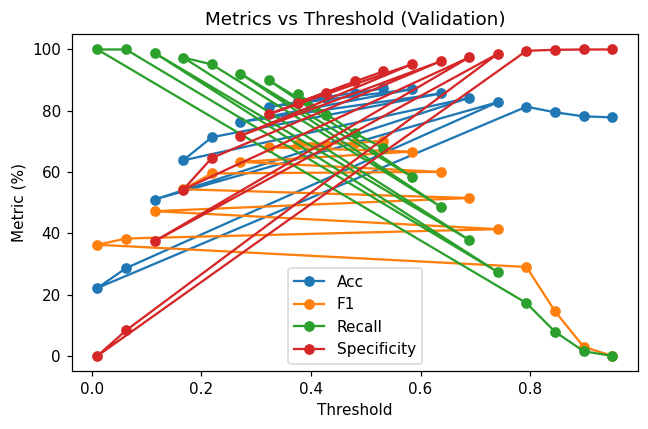


>>> The best threshold on validation set: best_t = 0.532

[Best threshold model @ Test (t=0.532)]
Accuracy (%)        : 85.062
Precision (%)       : 69.163
Recall (%)          : 58.801
F1-Score (%)        : 63.563
Specificity (%)     : 92.537
ROC-AUC (%)         : 89.864
Precision-recall (%): 74.196

[Best threshold model @ Val (t=0.532)]
Accuracy (%)        : 87.303
Precision (%)       : 72.984
Recall (%)          : 67.790
F1-Score (%)        : 70.291


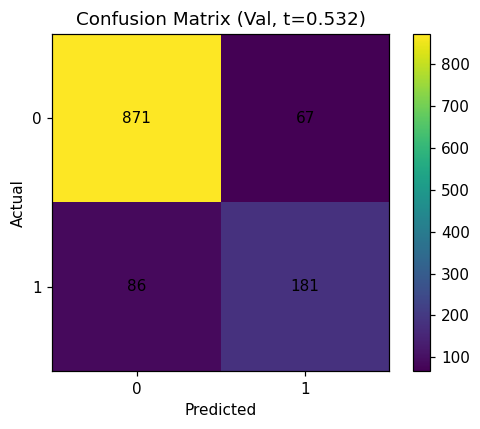

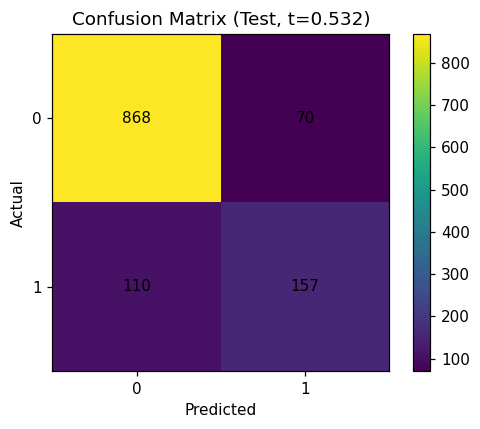

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(index=False, 
                                     formatters={"threshold": "{:.3f}".format,
                                                 "acc": "{:.3f}".format,
                                                 "prec": "{:.3f}".format,
                                                 "rec": "{:.3f}".format,
                                                 "f1": "{:.3f}".format,
                                                 "spec": "{:.3f}".format}))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted

def plot_threshold_metrics(df_thr, out_dir, prefix="val_thr"):
    os.makedirs(out_dir, exist_ok=True)

    thr = df_thr["threshold"].values

    plt.figure(figsize=(6,4))
    for key, label in [
        ("acc",  "Acc"),
        ("f1",   "F1"),
        ("rec",  "Recall"),
        ("spec", "Specificity"),
    ]:
        if key in df_thr.columns:
            plt.plot(thr, df_thr[key].values * 100.0, marker="o", label=label)

    plt.xlabel("Threshold")
    plt.ylabel("Metric (%)")
    plt.title("Metrics vs Threshold (Validation)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_metrics_vs_threshold.png"), dpi=300)
    plt.show()


df_thr_val = sweep_thresholds(yv_best, sv_best, sort_by="f1", verbose=True)
plot_threshold_metrics(df_thr_val, OUT_DIR, prefix="val_thr")

best_t = df_thr_val.iloc[0]["threshold"]
print(f"\n>>> The best threshold on validation set: best_t = {best_t:.3f}")

yt = np.asarray(yt_best).astype(int).ravel()
st = np.asarray(st_best).ravel()

y_test_pred = (st >= best_t).astype(int)

test_acc  = accuracy_score(yt, y_test_pred)
test_prec = precision_score(yt, y_test_pred, zero_division=0)
test_rec  = recall_score(yt, y_test_pred, zero_division=0)
test_f1   = f1_score(yt, y_test_pred, zero_division=0)

cm_test = confusion_matrix(yt, y_test_pred)
if cm_test.shape == (2, 2):
    tn, fp, fn, tp = cm_test.ravel()
    test_spec = tn / (tn + fp + 1e-8)
else:
    test_spec = float("nan")

test_roc = roc_auc_score(yt, st)
test_pr  = average_precision_score(yt, st)

print(f"\n[Best threshold model @ Test (t={best_t:.3f})]")
print(f"Accuracy (%)        : {test_acc*100:.3f}")
print(f"Precision (%)       : {test_prec*100:.3f}")
print(f"Recall (%)          : {test_rec*100:.3f}")
print(f"F1-Score (%)        : {test_f1*100:.3f}")
print(f"Specificity (%)     : {test_spec*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc*100:.3f}")
print(f"Precision-recall (%): {test_pr*100:.3f}")

y_val_pred = (np.asarray(sv_best) >= best_t).astype(int)
val_acc2  = accuracy_score(yv_best, y_val_pred)
val_prec2 = precision_score(yv_best, y_val_pred, zero_division=0)
val_rec2  = recall_score(yv_best, y_val_pred, zero_division=0)
val_f12   = f1_score(yv_best, y_val_pred, zero_division=0)

print(f"\n[Best threshold model @ Val (t={best_t:.3f})]")
print(f"Accuracy (%)        : {val_acc2*100:.3f}")
print(f"Precision (%)       : {val_prec2*100:.3f}")
print(f"Recall (%)          : {val_rec2*100:.3f}")
print(f"F1-Score (%)        : {val_f12*100:.3f}")

# --- Confusion matrix at best threshold ---

# Val
plot_confusion_matrix(
    y_true=yv_best,
    y_pred=y_val_pred,
    out_path=os.path.join(OUT_DIR, f"confmat_val_best_t_{best_t:.3f}.png"),
    title=f"Confusion Matrix (Val, t={best_t:.3f})"
)

# Test
plot_confusion_matrix(
    y_true=yt,
    y_pred=y_test_pred,
    out_path=os.path.join(OUT_DIR, f"confmat_test_best_t_{best_t:.3f}.png"),
    title=f"Confusion Matrix (Test, t={best_t:.3f})"
)

In [55]:
import pandas as pd

rows = [
    {
        "Split": "Train (Best)",
        "Accuracy (%)":         train_pct["acc"],
        "Precision (%)":        train_pct["prec"],
        "Recall (%)":           train_pct["rec"],
        "F1-Score (%)":         train_pct["f1"],
        "Specificity (%)":      train_pct["spec"],
        "ROC-AUC (%)":          train_pct["roc_auc"],
        "Precision-recall (%)": train_pct["pr_auc"],
    },
    {
        "Split": "Val (Best)",
        "Accuracy (%)":         val_pct["acc"],
        "Precision (%)":        val_pct["prec"],
        "Recall (%)":           val_pct["rec"],
        "F1-Score (%)":         val_pct["f1"],
        "Specificity (%)":      val_pct["spec"],
        "ROC-AUC (%)":          val_pct["roc_auc"],
        "Precision-recall (%)": val_pct["pr_auc"],
    },
    {
        "Split": "Test (Best)",
        "Accuracy (%)":         test_pct["acc"],
        "Precision (%)":        test_pct["prec"],
        "Recall (%)":           test_pct["rec"],
        "F1-Score (%)":         test_pct["f1"],
        "Specificity (%)":      test_pct["spec"],
        "ROC-AUC (%)":          test_pct["roc_auc"],
        "Precision-recall (%)": test_pct["pr_auc"],
    },
]

df_best = pd.DataFrame(rows)
print(df_best)

df_best.to_csv(os.path.join(OUT_DIR, "best_train_val_test_metrics_convnextv2.csv"), index=False, mode="w")


          Split  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  \
0  Train (Best)        87.471         95.610      78.548        86.243   
1    Val (Best)        86.639         69.485      70.787        70.130   
2   Test (Best)        85.145         68.033      62.172        64.971   

   Specificity (%)  ROC-AUC (%)  Precision-recall (%)  
0           96.393       97.167                96.969  
1           91.151       91.256                75.411  
2           91.684       89.864                74.196  
